# Import Libraries

In [ ]:
import numpy as np
import torch
from torch import optim

In [ ]:
#Code for ASGD ported from https://github.com/rahulkidambi/AccSGD

from torch.optim.optimizer import Optimizer, required
import copy

class AccSGD(Optimizer):
    r"""Implements the algorithm proposed in https://arxiv.org/pdf/1704.08227.pdf, which is a provably accelerated method 
    for stochastic optimization. This has been employed in https://openreview.net/forum?id=rJTutzbA- for training several 
    deep learning models of practical interest. This code has been implemented by building on the construction of the SGD 
    optimization module found in pytorch codebase.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate (required)
        kappa (float, optional): ratio of long to short step (default: 1000)
        xi (float, optional): statistical advantage parameter (default: 10)
        smallConst (float, optional): any value <=1 (default: 0.7)
    Example:
        >>> from AccSGD import *
        >>> optimizer = AccSGD(model.parameters(), lr=0.1, kappa = 1000.0, xi = 10.0)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=0.001, kappa = 1000.0, xi = 10.0, smallConst = 0.7, weight_decay=0):
        defaults = dict(lr=lr, kappa=kappa, xi=xi, smallConst=smallConst,
                        weight_decay=weight_decay)
        super(AccSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AccSGD, self).__setstate__(state)

    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            large_lr = (group['lr']*group['kappa'])/(group['smallConst'])
            Alpha = 1.0 - ((group['smallConst']*group['smallConst']*group['xi'])/group['kappa'])
            Beta = 1.0 - Alpha
            zeta = group['smallConst']/(group['smallConst']+Beta)
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = copy.deepcopy(p.data)
                buf = param_state['momentum_buffer']
                buf.mul_((1.0/Beta)-1.0)
                buf.add_(-large_lr,d_p)
                buf.add_(p.data)
                buf.mul_(Beta)

                p.data.add_(-group['lr'],d_p)
                p.data.mul_(zeta)
                p.data.add_(1.0-zeta,buf)

        return loss



# Define the Discrete/Gaussian Distribution

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#Randomly select a weight matrix
# w = torch.rand(2,1)
w = torch.tensor([[0.5],[2]])

#Define Gaussian Distribution as per Original Paper
def gaussian(num_samples,k):    
    a = torch.distributions.multivariate_normal.MultivariateNormal(
        loc=torch.Tensor([0,0]), covariance_matrix=torch.Tensor([[1, 0],[0, 1/k]])).sample((num_samples,))
    b = a@w
    if torch.cuda.is_available(): 
        return Variable(a).cuda(),Variable(b).cuda()
    else:
        return Variable(a),Variable(b)

#Define Discrete Distribution as per Original Paper
def discrete(num_samples,k):
  a = torch.zeros(num_samples,2)
  b = torch.zeros(num_samples,1)

  for i in range(num_samples):
    dist = torch.multinomial(input= torch.tensor([0.5, 0.5]),num_samples=2).float()
    a[i] = dist

  a[:,1]=a[:,1].float()*(2.0/k)
  b = a @ w  

  if torch.cuda.is_available(): 
        return Variable(a).cuda(),Variable(b).cuda()
  else:
        return Variable(a),Variable(b)

#Define a simplistic Neural Network for Linear Regression
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression,self).__init__()
        self.linear = nn.Linear(2,1)

    def forward(self,input):
        output = self.linear(input)
        return output

# **Discrete**

## 1. SGD

In [ ]:
def Discrete_SGD(n, epochs):
 
  seed = 7
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  #Define Hyperparameters
  lr = 0.01
  Num_samples = 1000

  k_set = torch.zeros(n)

  minimum_loss = torch.zeros(n)  
  rate_sgd = np.zeros(n)
    
  for i in range (n):
    k = 2**(i+4)
    k_set[i] = k

    iterations = 5*k

    loss_list = torch.zeros(n, iterations).cuda()

    #Generate Training Data
    X, y = discrete(Num_samples, k_set[i])

    model = LinearRegression().cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_func = nn.MSELoss()
    output = model(X)
    initial_loss = loss_func(output,y)
    prev_loss = 1e8
    initial_loss = initial_loss.item()
    minimum_loss[i] = initial_loss
    index = 0

    #Run simulations for #epochs and take the average across all of them
    for epoch in range(epochs):

      for t in range(iterations):

          optimizer.zero_grad()
          y_hat = model(X)
          loss = loss_func(y_hat,y)
          loss_list[i][t] = loss.item()
          loss.backward()
          optimizer.step()
          current_loss = loss.item()

          #Update Minimum Loss and corresponding index found till now
          if current_loss != 0 and minimum_loss[i] > current_loss:
            minimum_loss[i] = current_loss
            index = t+1

          prev_loss = current_loss
    
      #Verify Geometric Convergence Criteria
      print("Verify convergence, k = {}, epoch = {}, t = {}".format(k, epoch, t))
      for j in range (int(iterations/2), iterations):
        if loss_list[i][j] < initial_loss:
          pass
        else:
          print("Faile to Converge!")
          break

      y_hat = model(X)
      final_loss = loss_func(y_hat,y)
      final_loss = final_loss.item()
      #Final Loss = 0 -> True Convergence of Loss Function -> Divergence in Convergence Performance Expression

      #Compute reciprocal of Convergence Performance value
      rate_sgd[i] += index/(np.log(initial_loss) - np.log(minimum_loss[i]))

    #Average out across #epochs
    rate_sgd[i] = rate_sgd[i]/epochs

    print("initial loss", initial_loss)
    print("final loss", final_loss)
    print(index, minimum_loss[i])
    print("inverse rate at k = {} is {}\n".format(k,rate_sgd[i]))
      
  return rate_sgd


In [ ]:
rate_sgd = Discrete_SGD(9, 1)
print("Inverse Rates obtained :")
print(repr(rate_sgd))

Verify convergence, k = 16, epoch = 0, t = 79
initial loss 0.9465574026107788
final loss 0.013030246831476688
80 tensor(0.0137)
inverse rate at k = 16 is 18.902963638305664

Verify convergence, k = 32, epoch = 0, t = 159
initial loss 0.09302361309528351
final loss 0.000415690679801628
160 tensor(0.0004)
inverse rate at k = 32 is 29.625465393066406

Verify convergence, k = 64, epoch = 0, t = 319
initial loss 0.9204031229019165
final loss 0.005663178861141205
320 tensor(0.0057)
inverse rate at k = 64 is 62.94937515258789

Verify convergence, k = 128, epoch = 0, t = 639
initial loss 0.040975455194711685
final loss 8.346117829205468e-05
640 tensor(8.4115e-05)
inverse rate at k = 128 is 103.41696166992188

Verify convergence, k = 256, epoch = 0, t = 1279
initial loss 0.11091545224189758
final loss 6.760135420336155e-06
1280 tensor(6.8115e-06)
inverse rate at k = 256 is 131.98724365234375

Verify convergence, k = 512, epoch = 0, t = 2559
initial loss 0.6170855760574341
final loss 9.387574051

## 2. Heavy Ball

In [ ]:
def Discrete_HeavyBall(n, epochs):
 
  seed = 10
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  #Define Hyperparameters
  lr = 0.01
  momentum = 0.5
  Num_samples = 1000

  k_set = torch.zeros(n)

  minimum_loss = torch.zeros(n)
  
  rate_heavyball = np.zeros(n)
    
  for i in range (n):
    k = 2**(i+4)
    k_set[i] = k

    iterations = 5*k

    loss_list = torch.zeros(n, iterations).cuda()

    #Generate Training Data
    X, y = discrete(Num_samples, k_set[i])

    model = LinearRegression().cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = momentum)
    loss_func = nn.MSELoss()
    output = model(X)
    initial_loss = loss_func(output,y)
    prev_loss = 1e8
    initial_loss = initial_loss.item()
    minimum_loss[i] = initial_loss
    index = 0

    #Run simulations for #epochs and take the average across all of them
    for epoch in range(epochs):

      for t in range(iterations):

          optimizer.zero_grad()
          y_hat = model(X)
          loss = loss_func(y_hat,y)
          loss_list[i][t] = loss.item()
          loss.backward()
          optimizer.step()
          current_loss = loss.item()

          #Update Minimum Loss and corresponding index found till now
          if current_loss != 0 and minimum_loss[i] > current_loss:
            minimum_loss[i] = current_loss
            index = t+1

          prev_loss = current_loss
    
      # verify convergence
      print("Verify convergence, k = {}, epoch = {}, t = {}".format(k, epoch, t))
      for j in range (int(t/2), t):
        if loss_list[i][j] < initial_loss:
          pass
        else:
          print("Failed to Converge!")
          break


      y_hat = model(X)
      final_loss = loss_func(y_hat,y)
      final_loss = final_loss.item()
      #Final Loss = 0 -> True Convergence of Loss Function -> Divergence in Convergence Performance Expression

      #Compute reciprocal of Convergence Performance value
      rate_heavyball[i] += index/(np.log(initial_loss) - np.log(minimum_loss[i]))

    #Average out across #epochs
    rate_heavyball[i] = rate_heavyball[i]/epochs

    print("initial loss", initial_loss)
    print("final loss", final_loss)
    print("inverse rate at k = {} is {}\n".format(k,rate_heavyball[i]))
        
  return rate_heavyball


In [ ]:
rate_HeavyBall = Discrete_HeavyBall(9, 1)
print("Inverse Rates obtained :")
print(repr(rate_HeavyBall))

Verify convergence, k = 16, epoch = 0, t = 79
initial loss 0.5496789216995239
final loss 0.03235037997364998
inverse rate at k = 16 is 28.406814575195312

Verify convergence, k = 32, epoch = 0, t = 159
initial loss 0.7807646989822388
final loss 0.002331214491277933
inverse rate at k = 32 is 27.594758987426758

Verify convergence, k = 64, epoch = 0, t = 319
initial loss 0.48875364661216736
final loss 2.8795679099857807e-05
inverse rate at k = 64 is 32.909149169921875

Verify convergence, k = 128, epoch = 0, t = 639
initial loss 0.21609127521514893
final loss 8.211965905502439e-06
inverse rate at k = 128 is 62.97650909423828

Verify convergence, k = 256, epoch = 0, t = 1279
initial loss 1.3539786338806152
final loss 8.827832909119593e-11
inverse rate at k = 256 is 54.61265563964844

Verify convergence, k = 512, epoch = 0, t = 2559
initial loss 0.07302531599998474
final loss 5.69190961724475e-13
inverse rate at k = 512 is 60.67521286010742

Verify convergence, k = 1024, epoch = 0, t = 511

## 3. NAG

In [ ]:
def Discrete_NAG(n, epochs):
 
  seed = 10
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  #Define Hyperparameters
  lr = 0.01
  momentum = 0.5
  Num_samples = 1000

  k_set = torch.zeros(n)

  final_loss=torch.zeros(n)
  minimum_loss=torch.zeros(n)
  
  rate_NAG = np.zeros(n)
    
  for i in range (n):
    k = 2**(i+4)
    k_set[i] = k

    iterations = 5*k

    loss_list = torch.zeros(n, iterations).cuda()

    #Generate Training Data
    X, y = discrete(Num_samples, k_set[i])

    model = LinearRegression().cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = momentum, nesterov = True)
    loss_func = nn.MSELoss()
    output = model(X)
    initial_loss = loss_func(output,y)
    prev_loss = 1e8
    initial_loss = initial_loss.item()
    minimum_loss[i] = initial_loss
    index = 0

    #Run simulations for #epochs and take the average across all of them
    for epoch in range(epochs):

      for t in range(iterations):

          optimizer.step()
          y_hat = model(X)
          loss = loss_func(y_hat,y)
          loss_list[i][t] = loss.item()
          optimizer.zero_grad()
          loss.backward()
          current_loss = loss.item()

          #Update Minimum Loss and corresponding index found till now
          if current_loss != 0 and minimum_loss[i] > current_loss:
            minimum_loss[i] = current_loss
            index = t+1

          prev_loss = current_loss

    
      #Verify Geometric Convergence Criteria
      print("Verify convergence, k = {}, epoch = {}, t = {}".format(k, epoch, t))
      for j in range (int(t/2), t):
        if loss_list[i][j] < initial_loss:
          pass
        else:
          print("Failed to Converge!")
          break

      y_hat = model(X)
      final_loss = loss_func(y_hat,y)
      final_loss = final_loss.item()
      #Final Loss = 0 -> True Convergence of Loss Function -> Divergence in Convergence Performance Expression

      #Compute reciprocal of Convergence Performance value
      rate_NAG[i] += index/(np.log(initial_loss) - np.log(minimum_loss[i]))

    #Average out across #epochs
    rate_NAG[i] = rate_NAG[i]/epochs

    print("initial loss", initial_loss)
    print("final loss", final_loss)
    print("inverse rate at k = {} is {}\n".format(k,rate_NAG[i]))
        
  return rate_NAG


In [ ]:
rate_NAG = Discrete_NAG(9, 1)
print("Inverse Rates obtained :")
print(repr(rate_NAG))

Verify convergence, k = 16, epoch = 0, t = 79
initial loss 0.5496789216995239
final loss 0.03280406817793846
inverse rate at k = 16 is 28.381053924560547

Verify convergence, k = 32, epoch = 0, t = 159
initial loss 0.7807646989822388
final loss 0.00237244158051908
inverse rate at k = 32 is 27.603557586669922

Verify convergence, k = 64, epoch = 0, t = 319
initial loss 0.48875364661216736
final loss 2.9594966690638103e-05
inverse rate at k = 64 is 32.94889831542969

Verify convergence, k = 128, epoch = 0, t = 639
initial loss 0.21609127521514893
final loss 8.593903658038471e-06
inverse rate at k = 128 is 63.1636962890625

Verify convergence, k = 256, epoch = 0, t = 1279
initial loss 1.3539786338806152
final loss 9.66941388069742e-11
inverse rate at k = 256 is 54.78861999511719

Verify convergence, k = 512, epoch = 0, t = 2559
initial loss 0.07302531599998474
final loss 5.699039872832101e-13
inverse rate at k = 512 is 60.94578170776367

Verify convergence, k = 1024, epoch = 0, t = 5119
i

## 3. ASGD

In [ ]:
def Discrete_ASGD(n, epochs):
 
  seed = 7
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  #Define Hyperparameters
  lr = 0.1
  Num_samples = 1000

  k_set = torch.zeros(n)

  minimum_loss=torch.zeros(9)
  
  rate_ASGD = np.zeros(n)
    
  for i in range (n):
    k = 2**(i+4)
    k_set[i] = k

    iterations = 5*k

    llr = 2*k
    sap = np.sqrt(2/3 * k)

    loss_list = torch.zeros(n, iterations).cuda()

    #Generate Training Data
    X, y = discrete(Num_samples, k_set[i])

    model = LinearRegression().cuda()
    optimizer = AccSGD(model.parameters(), lr=lr,  kappa = llr, xi = sap)
    loss_func = nn.MSELoss()
    output = model(X)
    initial_loss = loss_func(output,y)
    prev_loss = 1e8
    initial_loss = initial_loss.item()
    minimum_loss[i] = initial_loss
    index = 0

    #Run simulations for #epochs and take the average across all of them
    for epoch in range(epochs):

      for t in range(iterations):

          optimizer.zero_grad()
          y_hat = model(X)
          loss = loss_func(y_hat,y)
          loss_list[i][t] = loss.data
          loss.backward()
          optimizer.step()
          current_loss = loss.item()

          #Update Minimum Loss and corresponding index found till now
          if current_loss != 0 and minimum_loss[i] > current_loss:
            minimum_loss[i] = current_loss
            index = t+1

          prev_loss = current_loss

    
    
      # verify convergence
      print("Verify convergence, k = {}, epoch = {}, t = {}".format(k, epoch, t))
      for j in range (int(iterations/2), int(iterations)):
        if loss_list[i][j] < initial_loss:
          pass
        else:
          print("not converge")
          break

      y_hat = model(X)
      final_loss = loss_func(y_hat,y)
      final_loss = final_loss.item()
      #Final Loss = 0 -> True Convergence of Loss Function -> Divergence in Convergence Performance Expression

      #Compute reciprocal of Convergence Performance value
      rate_ASGD[i] += index/(np.log(initial_loss) - np.log(minimum_loss[i]))

    #Average out across #epochs
    rate_ASGD[i] = rate_ASGD[i]/epochs

    print("initial loss", initial_loss)
    print("final loss", final_loss)
    print("inverse rate at k = {} is {}\n".format(k,rate_ASGD[i]))
        
  return rate_ASGD



In [ ]:
rate_ASGD = Discrete_ASGD(9, 1)
print("Inverse Rates obtained :")
print(repr(rate_ASGD))

Verify convergence, k = 16, epoch = 0, t = 79
initial loss 0.9465574026107788
final loss 5.008101711112545e-10
inverse rate at k = 16 is 1.9998067617416382

Verify convergence, k = 32, epoch = 0, t = 159
initial loss 0.09302361309528351
final loss 3.386823373835446e-12
inverse rate at k = 32 is 4.3712592124938965

Verify convergence, k = 64, epoch = 0, t = 319
initial loss 0.9204031229019165
final loss 3.989642072114476e-15
inverse rate at k = 64 is 7.818027496337891

Verify convergence, k = 128, epoch = 0, t = 639
initial loss 0.040975455194711685
final loss 1.7201796026350955e-15
inverse rate at k = 128 is 8.961135864257812

Verify convergence, k = 256, epoch = 0, t = 1279
initial loss 0.11091545224189758
final loss 1.0035445188743978e-15
inverse rate at k = 256 is 11.485301971435547

Verify convergence, k = 512, epoch = 0, t = 2559
initial loss 0.6170855760574341
final loss 6.99440516763505e-18
inverse rate at k = 512 is 13.136716842651367

Verify convergence, k = 1024, epoch = 0, t

In [ ]:
print("SGD Inverse Rates: ",repr(rate_sgd))
print("Heavy Ball Inverse Rates: ",repr(rate_HeavyBall))
print("NAG Inverse Rates: ",repr(rate_NAG))
print("ASGD Inverse Rates: ",repr(rate_ASGD))

SGD Inverse Rates:  array([ 18.90296364,  29.62546539,  62.94937515, 103.41696167,
       131.98724365, 113.26994324, 125.274086  , 124.95042419,
       129.80969238])
Heavy Ball Inverse Rates:  array([28.40681458, 27.59475899, 32.90914917, 62.97650909, 54.61265564,
       60.67521286, 58.76751328, 68.74304199, 73.45604706])
NAG Inverse Rates:  array([28.38105392, 27.60355759, 32.94889832, 63.16369629, 54.78862   ,
       60.94578171, 57.50931549, 68.85661316, 73.56845856])
ASGD Inverse Rates:  array([ 8.88384056, 22.465168  , 29.07191849, 14.60667515, 26.9486866 ,
       24.54883957, 36.21957397, 41.33992004, 76.59269714])


## Load Saved Rates

In [ ]:
#Uncomment the lines below to load the previously saved inverse rates:

# rate_sgd = np.array([ 18.90296364,  29.62546539,  62.94937515, 103.41696167,
#       131.98724365, 113.26994324, 125.274086  , 124.95042419,
#       129.80969238])
# rate_HeavyBall = np.array([28.40681458, 27.59475899, 32.90914917, 62.97650909, 54.61265564,
#       60.67521286, 58.76751328, 68.74304199, 73.45604706])
# rate_NAG = np.array([ 9.31748772, 23.92021561, 42.92202377, 57.00369263, 65.67341614,
#       61.8259201 , 63.31064606, 63.18315506, 63.22632217])
# rate_ASGD = np.array([ 1.99980676,  4.37125921,  7.8180275 ,  8.96113586, 11.48530197,
#       13.13671684, 13.22907543, 20.26182556, 17.4631176 ])

## 5. Plots

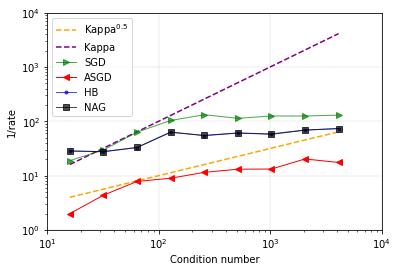

In [ ]:
import matplotlib.pyplot as plt
 
k_set = []

for i in range(0,9):
  k_set.append(2**(i+4))
  
k_line_x = np.array([np.min(k_set),np.max(k_set)])
k_line_y = k_line_x
sqrt_k_line_x = np.array([np.min(k_set),np.max(k_set)])
sqrt_k_line_y = np.sqrt(sqrt_k_line_x)
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.plot(sqrt_k_line_x, sqrt_k_line_y, linestyle = '--',label='Kappa$^{0.5}$',c='orange')
plt.plot(k_line_x, k_line_y, linestyle = '--',label='Kappa',c='purple')

plt.plot(k_set,rate_sgd,c='g',linewidth=1.0, marker='>',label='SGD',alpha=.7)
plt.plot(k_set,rate_ASGD,c='r',marker='<',linewidth=1.0, label='ASGD')
plt.plot(k_set,rate_HeavyBall,c='b', marker='.',linewidth=1.0, label='HB',alpha=.7)
plt.plot(k_set,rate_NAG,c='k', marker='s',linewidth=1.0, label='NAG',alpha=.7)

plt.grid(color='k', linestyle='--', linewidth=.1)
plt.xlabel('Condition number')
plt.ylabel('1/rate')
plt.xlim(10,10**4)
plt.ylim(1,10**4)
plt.legend()

plt.savefig('Discrete_plot.png')



In [ ]:
#Uncomment the below lines to download the plot

# from google.colab import files
# files.download('Discrete_plot.png')

# Gaussian

## 1. SGD

In [ ]:
def Gaussian_SGD(n, epochs):
  
  seed = 7
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  
  #Define Hyperparameters
  lr = 0.84
  Num_samples = 1000

  k_set = torch.zeros(n)

  minimum_loss = torch.zeros(n)
  rate_sgd = np.zeros(n)
    
  for i in range (n):
    k = 2**(i+4)
    k_set[i] = k

    iterations = 5*k

    loss_list = torch.zeros(n, iterations).cuda()

    #Generate Training Data
    X, y = gaussian(Num_samples, k_set[i])

    model = LinearRegression().cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0)
    loss_func = nn.MSELoss()
    output = model(X)
    initial_loss = loss_func(output,y)
    prev_loss = 1e8
    initial_loss = initial_loss.item()
    minimum_loss[i] = initial_loss
    index = 0

    #Run simulations for #epochs and take the average across all of them
    for epoch in range(epochs):

      for t in range(iterations):

          optimizer.zero_grad()
          y_hat = model(X)
          loss = loss_func(y_hat,y)
          loss_list[i][t] = loss.item()
          loss.backward()
          optimizer.step()
          current_loss = loss.item()

          #Update Minimum Loss and corresponding index found till now
          if current_loss != 0 and minimum_loss[i] > current_loss:
            minimum_loss[i] = current_loss
            index = t+1

          prev_loss = current_loss
    
      #Verify Geometric Convergence Criteria
      print("Verify convergence, k = {}, epoch = {}, t = {}".format(k, epoch, t))
      for j in range (int(iterations/2), iterations):   
        if loss_list[i][j] < initial_loss:
          pass

        else:
          print("Failed to Converge!")
          break

      y_hat = model(X)
      final_loss = loss_func(y_hat,y)
      final_loss = final_loss.item()
      #Final Loss = 0 -> True Convergence of Loss Function -> Divergence in Convergence Performance Expression

      #Compute reciprocal of Convergence Performance value
      rate_sgd[i] += index/(np.log(initial_loss) - np.log(minimum_loss[i]))

    #Average out across #epochs
    rate_sgd[i] = rate_sgd[i]/epochs

    print("initial loss", initial_loss)
    print("final loss", final_loss)
    print("inverse rate at k = {} is {}\n".format(k,rate_sgd[i]))
        
  return rate_sgd


In [ ]:
rate_sgd = Gaussian_SGD(9, 1)
print("Inverse Rates obtained :")
print(repr(rate_sgd))

Verify convergence, k = 16, epoch = 0, t = 79
initial loss 0.6168534159660339
final loss 5.52911760820507e-09
inverse rate at k = 16 is 4.368748188018799

Verify convergence, k = 32, epoch = 0, t = 159
initial loss 0.6003409624099731
final loss 9.89293313935491e-10
inverse rate at k = 32 is 7.958076000213623

Verify convergence, k = 64, epoch = 0, t = 319
initial loss 0.8451460003852844
final loss 1.2897705126135861e-08
inverse rate at k = 64 is 17.828983306884766

Verify convergence, k = 128, epoch = 0, t = 639
initial loss 0.17004670202732086
final loss 1.0206253620026473e-09
inverse rate at k = 128 is 33.853607177734375

Verify convergence, k = 256, epoch = 0, t = 1279
initial loss 0.5446541905403137
final loss 5.321741380903688e-10
inverse rate at k = 256 is 61.735992431640625

Verify convergence, k = 512, epoch = 0, t = 2559
initial loss 0.1294461339712143
final loss 3.5589609037600667e-10
inverse rate at k = 512 is 129.91513061523438

Verify convergence, k = 1024, epoch = 0, t = 

## 2. Heavy Ball

In [ ]:
def Gaussian_HeavyBall(n, epochs):
 
  seed = 7
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  #Define Hyperparameters
  lr = 1.0
  momentum = 0.6
  Num_samples = 1000

  k_set = torch.zeros(n)

  minimum_loss=torch.zeros(n)
  rate_heavyball = np.zeros(n)
    
  for i in range (n):
    k = 2**(i+4)
    k_set[i] = k

    iterations = 5*k

    loss_list = torch.zeros(n, iterations).cuda()

    #Generate Training Data
    X, y = gaussian(Num_samples, k_set[i])

    model = LinearRegression().cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = momentum)
    loss_func = nn.MSELoss()
    output = model(X)
    initial_loss = loss_func(output,y)
    prev_loss = 1e8
    initial_loss = initial_loss.item()
    minimum_loss[i] = initial_loss
    index = 0

    #Run simulations for #epochs and take the average across all of them
    for epoch in range(epochs):

      for t in range(iterations):

          optimizer.zero_grad()
          y_hat = model(X)
          loss = loss_func(y_hat,y)
          loss_list[i][t] = loss.item()
          loss.backward()
          optimizer.step()
          current_loss = loss.item()

          #Update Minimum Loss and corresponding index found till now
          if current_loss != 0 and minimum_loss[i] > current_loss:
            minimum_loss[i] = current_loss
            index = t+1

          prev_loss = current_loss
    
      #Verify Geometric Convergence Criteria
      print("Verify convergence, k = {}, epoch = {}, t = {}".format(k, epoch, t))
      for j in range (int(iterations/2), int(iterations)):
        if loss_list[i][j] < initial_loss:
          pass

        else:
          print("Failed to Converge!")
          break

      y_hat = model(X)
      final_loss = loss_func(y_hat,y)
      final_loss = final_loss.item()
      #Final Loss = 0 -> True Convergence of Loss Function -> Divergence in Convergence Performance Expression

      #Compute reciprocal of Convergence Performance value
      rate_heavyball[i] += index/(np.log(initial_loss) - np.log(minimum_loss[i]))

    #Average out across #epochs
    rate_heavyball[i] = rate_heavyball[i]/epochs
    
    print("initial loss", initial_loss)
    print("final loss", final_loss)
    print("inverse rate at k = {} is {}\n".format(k,rate_heavyball[i]))
        
  return rate_heavyball


In [ ]:
rate_HeavyBall = Gaussian_HeavyBall(9, 1)
print("Inverse Rates obtained :")
print(repr(rate_HeavyBall))

Verify convergence, k = 16, epoch = 0, t = 79
initial loss 0.6168534159660339
final loss 2.8514313848461426e-15
inverse rate at k = 16 is 2.1801915168762207

Verify convergence, k = 32, epoch = 0, t = 159
initial loss 0.6003409624099731
final loss 2.5944216833749274e-15
inverse rate at k = 32 is 2.720959424972534

Verify convergence, k = 64, epoch = 0, t = 319
initial loss 0.8451460003852844
final loss 6.048136268882714e-15
inverse rate at k = 64 is 5.402040004730225

Verify convergence, k = 128, epoch = 0, t = 639
initial loss 0.17004670202732086
final loss 1.559067985660873e-14
inverse rate at k = 128 is 14.004690170288086

Verify convergence, k = 256, epoch = 0, t = 1279
initial loss 0.5446541905403137
final loss 3.1990841995854086e-14
inverse rate at k = 256 is 21.465036392211914

Verify convergence, k = 512, epoch = 0, t = 2559
initial loss 0.1294461339712143
final loss 6.723166809515999e-14
inverse rate at k = 512 is 44.72098922729492

Verify convergence, k = 1024, epoch = 0, t =

## 3. NAG

In [ ]:
def Gaussian_NAG(n, epochs):

  seed = 10
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
 
  #Define Hyperparameters
  lr = 0.6
  momentum = 0.7
  Num_samples = 1000

  k_set = torch.zeros(n)

  minimum_loss = torch.zeros(n)
  
  rate_NAG = np.zeros(n)
    
  for i in range (n):
    k = 2**(i+4)
    k_set[i] = k

    iterations = 5*k

    loss_list = torch.zeros(n, iterations).cuda()

    #Generate Training Data
    X, y = gaussian(Num_samples, k_set[i])

    model = LinearRegression().cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum = momentum, nesterov = True)
    loss_func = nn.MSELoss()
    output = model(X)
    initial_loss = loss_func(output,y)
    prev_loss = 1e8
    initial_loss = initial_loss.item()
    minimum_loss[i] = initial_loss
    
    index = 0

    #Run simulations for #epochs and take the average across all of them
    for epoch in range(epochs):

      for t in range(iterations):

          optimizer.zero_grad()
          y_hat = model(X)
          loss = loss_func(y_hat,y)
          loss_list[i][t] = loss.item()
          loss.backward()
          optimizer.step()
          current_loss = loss.item()

          #Update Minimum Loss and corresponding index found till now
          if current_loss != 0 and minimum_loss[i] > current_loss:
            minimum_loss[i] = current_loss
            index = t+1

          prev_loss = current_loss
    
      #Verify Geometric Convergence Criteria
      print("Verify convergence, k = {}, epoch = {}, t = {}".format(k, epoch, t))
      for j in range (int(iterations/2), int(iterations)):
        if loss_list[i][j] < initial_loss:
          pass
        else:
          print("Failed to Converge!")
          break

      y_hat = model(X)
      final_loss = loss_func(y_hat,y)
      final_loss = final_loss.item()
      #Final Loss = 0 -> True Convergence of Loss Function -> Divergence in Convergence Performance Expression

      #Compute reciprocal of Convergence Performance value
      rate_NAG[i] += index/(np.log(initial_loss) - np.log(minimum_loss[i]))

    #Average out across #epochs
    rate_NAG[i] = rate_NAG[i]/epochs

    print("initial loss", initial_loss)
    print("final loss", final_loss)
    print("inverse rate at k = {} is {}\n".format(k,rate_NAG[i]))
        
  return rate_NAG


In [ ]:
rate_NAG = Gaussian_NAG(9, 1)
print("Inverse Rates obtained :")
print(repr(rate_NAG))

Verify convergence, k = 16, epoch = 0, t = 79
initial loss 1.40354323387146
final loss 5.897154340100529e-15
inverse rate at k = 16 is 1.7264914512634277

Verify convergence, k = 32, epoch = 0, t = 159
initial loss 0.15205137431621552
final loss 5.281325812062868e-15
inverse rate at k = 32 is 1.8558833599090576

Verify convergence, k = 64, epoch = 0, t = 319
initial loss 0.35045599937438965
final loss 1.1187768715462988e-14
inverse rate at k = 64 is 7.382118225097656

Verify convergence, k = 128, epoch = 0, t = 639
initial loss 0.09415888786315918
final loss 2.541324999559818e-14
inverse rate at k = 128 is 14.668264389038086

Verify convergence, k = 256, epoch = 0, t = 1279
initial loss 0.9840759038925171
final loss 5.6013204599754396e-14
inverse rate at k = 256 is 30.023950576782227

Verify convergence, k = 512, epoch = 0, t = 2559
initial loss 0.5364075899124146
final loss 1.1051621044092658e-13
inverse rate at k = 512 is 56.20640182495117

Verify convergence, k = 1024, epoch = 0, t 

## 4. ASGD

In [ ]:
def Gaussian_ASGD(n, epochs):
 
  seed = 10
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  #Define Hyperparameters
  lr = .6
  Num_samples = 1000

  k_set = torch.zeros(n)

  minimum_loss = torch.zeros(n)
  
  rate_ASGD = np.zeros(n)
    
  for i in range (n):
    k = 2**(i+4)
    k_set[i] = k

    iterations = 5*k

    llr = 3*k
    sap = np.sqrt(3/2 * k)

    loss_list = torch.zeros(n, iterations).cuda()

    #Generate Training Data
    X, y = gaussian(Num_samples, k_set[i])

    model = LinearRegression().cuda()
    optimizer = AccSGD(model.parameters(), lr=lr,  kappa = llr, xi = sap)
    loss_func = nn.MSELoss()
    output = model(X)
    initial_loss = loss_func(output,y)
    prev_loss = 1e8
    initial_loss = initial_loss.item()
    minimum_loss[i] = initial_loss
    index = 0

    #Run simulations for #epochs and take the average across all of them
    for epoch in range(epochs):

      for t in range(iterations):

          optimizer.zero_grad()
          y_hat = model(X)
          loss = loss_func(y_hat,y)
          loss_list[i][t] = loss.data
          loss.backward()
          optimizer.step()
          current_loss = loss.item()

          #Update Minimum Loss and corresponding index found till now
          if current_loss != 0 and minimum_loss[i] > current_loss:
            minimum_loss[i] = current_loss
            index = t+1


      #Verify Geometric Convergence Criteria
      print("Verify convergence, k = {}, epoch = {}, t = {}".format(k, epoch, t))
      for j in range (int(iterations/2), int(iterations)):
        if loss_list[i][j] < initial_loss:
          pass
        else:
          print("Failed to Converge!")
          break

      y_hat = model(X)
      final_loss = loss_func(y_hat,y)
      final_loss = final_loss.item()
      #Final Loss = 0 -> True Convergence of Loss Function -> Divergence in Convergence Performance Expression

      #Compute reciprocal of Convergence Performance value
      rate_ASGD[i] += index/(np.log(initial_loss) - np.log(minimum_loss[i]))

    #Average out across #epochs
    rate_ASGD[i] = rate_ASGD[i]/epochs

    print("initial loss", initial_loss)
    print("final loss", final_loss)
    print("inverse rate at k = {} is {}\n".format(k,rate_ASGD[i]))
        
  return rate_ASGD


In [ ]:
rate_ASGD = Gaussian_ASGD(9, 1)
print("Inverse Rates obtained :")
print(repr(rate_ASGD))

Verify convergence, k = 16, epoch = 0, t = 79
initial loss 1.40354323387146
final loss 1.2747891631192942e-08
inverse rate at k = 16 is 3.080028772354126

Verify convergence, k = 32, epoch = 0, t = 159
initial loss 0.15205137431621552
final loss 1.0128040073276168e-10
inverse rate at k = 32 is 5.567091464996338

Verify convergence, k = 64, epoch = 0, t = 319
initial loss 0.35045599937438965
final loss 3.7534388032563204e-13
inverse rate at k = 64 is 8.071412086486816

Verify convergence, k = 128, epoch = 0, t = 639
initial loss 0.09415888786315918
final loss 5.181631897643521e-14
inverse rate at k = 128 is 12.828121185302734

Verify convergence, k = 256, epoch = 0, t = 1279
initial loss 0.9840759038925171
final loss 4.8566477174518535e-14
inverse rate at k = 256 is 17.51066017150879

Verify convergence, k = 512, epoch = 0, t = 2559
initial loss 0.5364075899124146
final loss 4.35057602465351e-14
inverse rate at k = 512 is 24.388856887817383

Verify convergence, k = 1024, epoch = 0, t = 

In [ ]:
print(repr(rate_sgd))
print(repr(rate_HeavyBall))
print(repr(rate_NAG))
print(repr(rate_ASGD))

array([  4.36874819,   7.958076  ,  17.82898331,  33.85360718,
        61.73599243, 129.91513062, 245.30897522, 459.52529907,
       866.46356201])
array([  2.18019152,   2.72095942,   5.40204   ,  14.00469017,
        21.46503639,  44.72098923,  89.74741364, 166.35313416,
       303.36691284])
array([  1.72649145,   1.85588336,   7.38211823,  14.66826439,
        30.02395058,  56.20640182, 101.02816772, 200.53100586,
       396.00482178])
array([ 3.08002877,  5.56709146,  8.07141209, 12.82812119, 17.51066017,
       24.38885689, 32.10813904, 40.01378632, 58.3797226 ])


## Load Saved Rates

In [ ]:
# Uncomment the lines below to load the previously saved inverse rates:

# rate_sgd = np.array([  4.36874819,   7.958076  ,  17.82898331,  33.85360718,
#         61.73599243, 129.91513062, 245.30897522, 459.52529907,
#        866.46356201])
# rate_HeavyBall = np.array([  2.18019152,   2.72095942,   5.40204   ,  14.00469017,
#         21.46503639,  44.72098923,  89.74741364, 166.35313416,
#        303.36691284])
# rate_NAG = np.array([  2.4225924 ,   2.58950305,   7.43218946,  19.05205154,
#         26.94716072,  63.30086136, 109.93840027, 207.37591553,
#        374.65203857])
# rate_ASGD = np.array([ 3.18003273,  5.22749901,  9.10929585, 12.27093124, 17.06051064,
#        25.92517662, 30.6316452 , 46.84978485, 60.91867828])

## 5. Plots

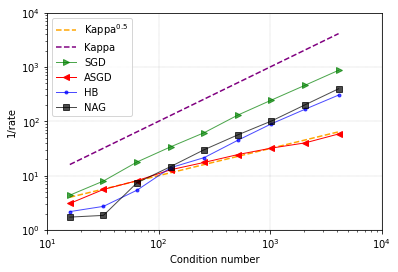

In [ ]:
import matplotlib.pyplot as plt
 

k_set = []

for i in range(0,9):
  k_set.append(2**(i+4))
  
k_line_x = np.array([np.min(k_set),np.max(k_set)])
k_line_y = k_line_x
sqrt_k_line_x = np.array([np.min(k_set),np.max(k_set)])
sqrt_k_line_y = np.sqrt(sqrt_k_line_x)
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.plot(sqrt_k_line_x, sqrt_k_line_y, linestyle = '--',label='Kappa$^{0.5}$',c='orange')
plt.plot(k_line_x, k_line_y, linestyle = '--',label='Kappa',c='purple')

plt.plot(k_set,rate_sgd,c='g',marker='>',linewidth=1.0, label='SGD',alpha=.7)
plt.plot(k_set,rate_ASGD,c='r',marker = '<', linewidth=1.0, label='ASGD')
plt.plot(k_set,rate_HeavyBall,c='b',marker='.',linewidth=1.0, label='HB',alpha=.7)
plt.plot(k_set,rate_NAG,c='k',marker='s',linewidth=1.0, label='NAG',alpha=.7)

plt.grid(color='k', linestyle='--', linewidth=.1)
plt.xlabel('Condition number')
plt.ylabel('1/rate')
plt.xlim(10,10**4)
plt.ylim(1,10**4)
plt.legend()

plt.savefig('Gaussian_plot.png')

In [ ]:
#Uncomment the below lines to download the plot

# from google.colab import files
# files.download('Gaussian_plot.png')

In [ ]:
#Generate Best Fit Lines for each of the curves obtained above

from scipy.optimize import curve_fit

def Line(x, a, b):
    return a * x + b

X = np.log(k_set)

y = np.log(rate_sgd)
popt, pcov = curve_fit(Line, X, y)
SGD_best_fit = np.exp(Line(X, popt[0], 0))
print('SGD slope:',popt[0])

y = np.log(rate_HeavyBall)
popt, pcov = curve_fit( Line, X, y)
HB_best_fit = np.exp(Line(X, popt[0], 0))
print('HB slope:',popt[0])

y = np.log(rate_NAG)
popt, pcov = curve_fit( Line, X, y)
NAG_best_fit = np.exp(Line(X, popt[0], 0))
print('NAG slope:',popt[0])


y = np.log(rate_ASGD)
popt, pcov = curve_fit(Line, X, y)
ASGD_best_fit = np.exp(Line(X, popt[0], 0))
print('ASGD slope:',popt[0])

SGD slope: 0.9597773175072807
HB slope: 0.9344576657067573
NAG slope: 1.0186674090410621
ASGD slope: 0.5070885867883129


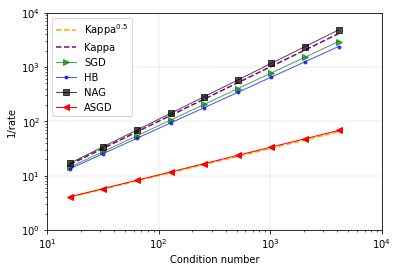

In [ ]:
k_line_x = np.array([np.min(k_set),np.max(k_set)])
k_line_y = k_line_x
sqrt_k_line_x = np.array([np.min(k_set),np.max(k_set)])
sqrt_k_line_y = np.sqrt(sqrt_k_line_x)
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.plot(sqrt_k_line_x, sqrt_k_line_y, linestyle = '--',label='Kappa$^{0.5}$',c='orange')
plt.plot(k_line_x, k_line_y, linestyle = '--',label='Kappa',c='purple')

plt.plot(k_set,SGD_best_fit,c='g',linewidth=1.0, marker='>',label='SGD',alpha=.7)
plt.plot(k_set,HB_best_fit,c='b', marker='.',linewidth=1.0, label='HB',alpha=.7)
plt.plot(k_set,NAG_best_fit,c='k', marker='s',linewidth=1.0, label='NAG',alpha=.7)
plt.plot(k_set,ASGD_best_fit,c='r',marker='<',linewidth=1.0, label='ASGD')

plt.grid(color='k', linestyle='--', linewidth=.1)
plt.xlabel('Condition number')
plt.ylabel('1/rate')
plt.xlim(10,10**4)
plt.ylim(1,10**4)
plt.legend()

plt.savefig('Gaussian_bestfit_plot.png')

In [ ]:
# Uncomment the below lines to download the plot

# from google.colab import files
# files.download('Gaussian_bestfit_plot.png')